#### Checking the GPU (applicable if using CUDA)

In [1]:
# !nvidia-smi -L

#### Imports

In [2]:
import torch
torch.cuda.empty_cache() # clear GPU memory to avoid CUDA out of memory error

import time
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Custom local imports
from src.dataloader import get_MELD_loaders
from audio.src.trainer import build_model, trainer

In [4]:
# To ignore the warnings from sklearn.metrics.classification_report
import warnings
warnings.filterwarnings("ignore") 

#### Prepare the arguments and data

In [5]:
import argparse

def parse_opt():
    parser = argparse.ArgumentParser()

    parser.add_argument('--no-cuda', action='store_true', default=True, help='does not use CUDA')
    parser.add_argument('--dir', type=str, default='./MELD_features/', help='dataset directory (for .pkl file)')
    parser.add_argument('--n-classes', type=int, default=7, help='number of classes')
    parser.add_argument('--val-split', type=float, default=0.1, help='validation split')
    parser.add_argument('--num-workers', type=int, default=0, help='number of workers')

    parser.add_argument('--loss-fn', type=str, default='masked_nll', help='loss function (masked_nll or unmaksed_weighted_nll or masked_mse)')
    parser.add_argument('--optimizer', type=str, default='sgd', help='optimizer (adam or sgd or rmsprop)')

    parser.add_argument('--lr', type=float, default=1e-4, metavar='LR', help='learning rate')
    parser.add_argument('--l2', type=float, default=3e-4, metavar='L2', help='L2 regularization weight')
    parser.add_argument('--dropout', type=float, default=0.2, metavar='dropout', help='dropout rate')
    parser.add_argument('--batch-size', type=int, default=30, metavar='BS', help='batch size')
    parser.add_argument('--epochs', type=int, default=50, metavar='E', help='number of epochs')
    
    parser.add_argument('--class-weight', action='store_true', default=False, help='use class weights (true or false)')
    parser.add_argument('--mu', type=float, default=0, help='class weight (mu)')

    parser.add_argument('--seed', type=int, default=42, metavar='seed', help='seed')
    
    parser.add_argument('--feature_type', type=str, default='multimodal', help='features (text or audio or multimodal)')
    parser.add_argument('--attention', type=str, default='simple', help='attention type (simple or general or general2 or concat or dot)')
    
    parser.add_argument('--verbose', action='store_true', default=True, help='verbose (true or false)')

    args = parser.parse_args("")
    
    return args

In [6]:
args = parse_opt()

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

#### Print the arguments to be used for model training

In [8]:
import pprint
pp = pprint.PrettyPrinter(depth=4) # PrettyPrinter is used to print the arguments in a clean way
pp.pprint(vars(args))

{'attention': 'simple',
 'batch_size': 30,
 'class_weight': False,
 'cuda': False,
 'dir': './MELD_features/',
 'dropout': 0.2,
 'epochs': 50,
 'feature_type': 'multimodal',
 'l2': 0.0003,
 'loss_fn': 'masked_nll',
 'lr': 0.0001,
 'mu': 0,
 'n_classes': 7,
 'no_cuda': True,
 'num_workers': 0,
 'optimizer': 'sgd',
 'seed': 42,
 'val_split': 0.1,
 'verbose': True}


In [9]:
global D_m

if args.feature_type == 'text':
    print("Running on the text features........")
    D_m = 600
elif args.feature_type == 'audio':
    print("Running on the audio features........")
    D_m = 300
elif args.feature_type == 'multimodal':
    print("Running on the multimodal features........")
    D_m = 900
    
D_g = D_q = D_r = 150
D_h = D_e = 100

Running on the multimodal features........


#### Initialize the model and view the architecture

In [10]:
model, optimizer, loss_function = build_model(D_m, D_q, D_g, D_r, D_e, D_h, args)

EmotionNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (emo_rnn_b): EmotionRNN(
    (dropout): Dropout(p=0.2, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(1200, 150)
      (p_cell): GRUCell(1050, 150)
      (pl_cell): GRUCell(1050, 150)
      (r_cell): GRUCell(1050, 150)
      (rl_cell): GRUCell(1050, 150)
      (e_cell): GRUCell(1200, 100)
      (dropout): Dropout(p=0.2, inplace=False)
      (attention): SimpleAttention(
        (scalar): Linear(in_features=150, out_features=1, bias=False)
      )
    )
  )
  (emo_rnn_f): EmotionRNN(
    (dropout): Dropout(p=0.2, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(1200, 150)
      (p_cell): GRUCell(1050, 150)
      (pl_cell): GRUCell(1050, 150)
      (r_cell): GRUCell(1050, 150)
      (rl_cell): GRUCell(1050, 150)
      (e_cell): GRUCell(1200, 100)
      (dropout): Dropout(p=0.2, inplace=False)
      (attention): SimpleAttention(
        (scalar): Linear(in_features=150, out_features=1, bias=Fals

#### Initialize the data loaders (train, validation, test)

In [11]:
train_loader, valid_loader , test_loader = get_MELD_loaders(path = args.dir + 'MELD_features_raw.pkl',
                                                            n_classes=args.n_classes,
                                                            valid=args.val_split,
                                                            batch_size=args.batch_size,
                                                            num_workers=args.num_workers)

#### Training phase

In [12]:
model, metrics, best_label, best_pred, best_mask, best_attn, test_class_report = trainer(args=args, 
                                                                                         model=model, 
                                                                                         train_loader=train_loader, 
                                                                                         valid_loader=valid_loader, 
                                                                                         test_loader=test_loader, 
                                                                                         optimizer=optimizer, 
                                                                                         loss_function=loss_function)

Epoch [1]/[50]	 Train Loss: 2.033	 Train Acc: 31.310%	 Train F1: 29.970	 Val Loss: 1.567	 Val Acc: 47.340%	 Val F1: 30.850	 Test Loss: 1.569	 Test Acc: 48.010%	 Test F1: 31.670	 Time: 28.38 sec
Epoch [2]/[50]	 Train Loss: 1.758	 Train Acc: 40.600%	 Train F1: 34.840	 Val Loss: 1.473	 Val Acc: 47.900%	 Val F1: 33.120	 Test Loss: 1.494	 Test Acc: 48.890%	 Test F1: 34.970	 Time: 25.46 sec
Epoch [3]/[50]	 Train Loss: 1.730	 Train Acc: 41.250%	 Train F1: 35.820	 Val Loss: 1.449	 Val Acc: 48.090%	 Val F1: 32.970	 Test Loss: 1.472	 Test Acc: 49.350%	 Test F1: 35.200	 Time: 23.91 sec
Epoch [4]/[50]	 Train Loss: 1.677	 Train Acc: 43.220%	 Train F1: 37.860	 Val Loss: 1.420	 Val Acc: 48.460%	 Val F1: 33.950	 Test Loss: 1.445	 Test Acc: 49.920%	 Test F1: 36.390	 Time: 24.46 sec
Epoch [5]/[50]	 Train Loss: 1.644	 Train Acc: 44.410%	 Train F1: 38.710	 Val Loss: 1.393	 Val Acc: 48.830%	 Val F1: 34.820	 Test Loss: 1.428	 Test Acc: 50.610%	 Test F1: 37.870	 Time: 25.03 sec
Epoch [6]/[50]	 Train Loss: 1.

In [13]:
train_losses = metrics['train']['train_losses']
train_fscores = metrics['train']['train_fscores']
train_accs = metrics['train']['train_accs']

val_losses = metrics['val']['val_losses']
val_fscores = metrics['val']['val_fscores']
val_accs = metrics['val']['val_accs']

test_losses = metrics['test']['test_losses']
test_fscores = metrics['test']['test_fscores']
test_accs = metrics['test']['test_accs']

best_fscore = metrics['best']['best_fscore']
best_loss = metrics['best']['best_loss']
best_acc = metrics['best']['best_acc']

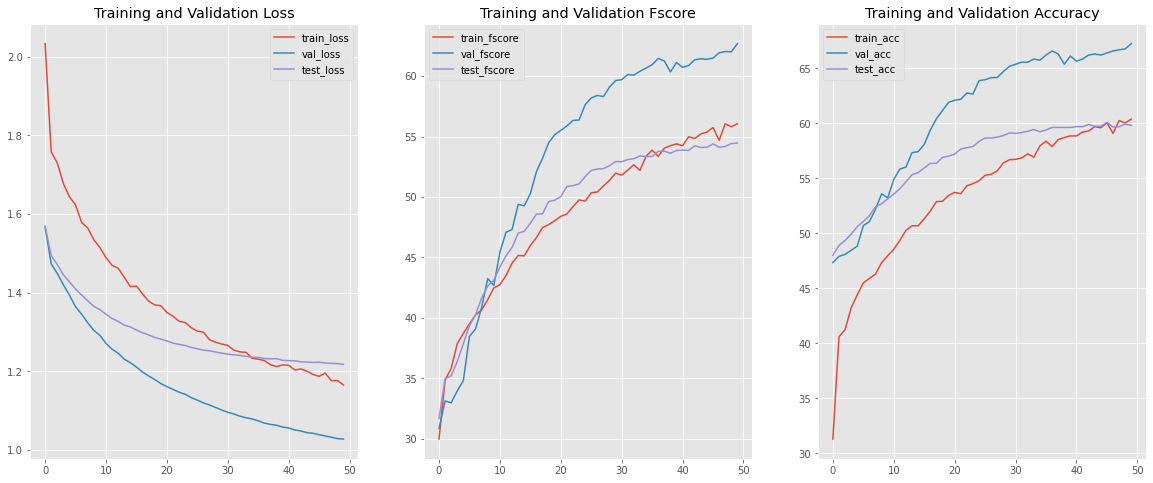

In [14]:
# plot the training and validation loss and accuracy
plt.style.use("ggplot")

fig = plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.plot(test_losses, label='test_loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_fscores, label='train_fscore')
plt.plot(val_fscores, label='val_fscore')
plt.plot(test_fscores, label='test_fscore')
plt.title('Training and Validation Fscore')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.plot(test_accs, label='test_acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#### Testing phase

In [15]:
print('[Metrics]\n')
print('Fscore: {:.3f}\tLoss: {:.3f}\tAccuracy: {:.3f}%\n'.format(best_fscore, best_loss, accuracy_score(best_label,best_pred,sample_weight=best_mask)*100))

[Metrics]

Fscore: 54.470	Loss: 1.218	Accuracy: 59.808%



In [16]:
print('Classification report:\n')
print(classification_report(best_label,best_pred,sample_weight=best_mask,digits=4))

Classification report:

              precision    recall  f1-score   support

           0     0.6729    0.8925    0.7673    1256.0
           1     0.5649    0.3096    0.4000     281.0
           2     0.0000    0.0000    0.0000      50.0
           3     1.0000    0.0096    0.0190     208.0
           4     0.4741    0.5000    0.4867     402.0
           5     0.0000    0.0000    0.0000      68.0
           6     0.4121    0.4348    0.4231     345.0

    accuracy                         0.5981    2610.0
   macro avg     0.4463    0.3066    0.2994    2610.0
weighted avg     0.5918    0.5981    0.5447    2610.0



In [17]:
print('Confusion matrix:\n')
print(confusion_matrix(best_label,best_pred,sample_weight=best_mask))

Confusion matrix:

[[1.121e+03 1.900e+01 0.000e+00 0.000e+00 6.500e+01 0.000e+00 5.100e+01]
 [9.500e+01 8.700e+01 0.000e+00 0.000e+00 5.200e+01 0.000e+00 4.700e+01]
 [2.900e+01 1.000e+00 0.000e+00 0.000e+00 1.100e+01 0.000e+00 9.000e+00]
 [1.420e+02 8.000e+00 0.000e+00 2.000e+00 2.100e+01 0.000e+00 3.500e+01]
 [1.360e+02 1.600e+01 0.000e+00 0.000e+00 2.010e+02 0.000e+00 4.900e+01]
 [3.200e+01 3.000e+00 0.000e+00 0.000e+00 1.000e+01 0.000e+00 2.300e+01]
 [1.110e+02 2.000e+01 0.000e+00 0.000e+00 6.400e+01 0.000e+00 1.500e+02]]


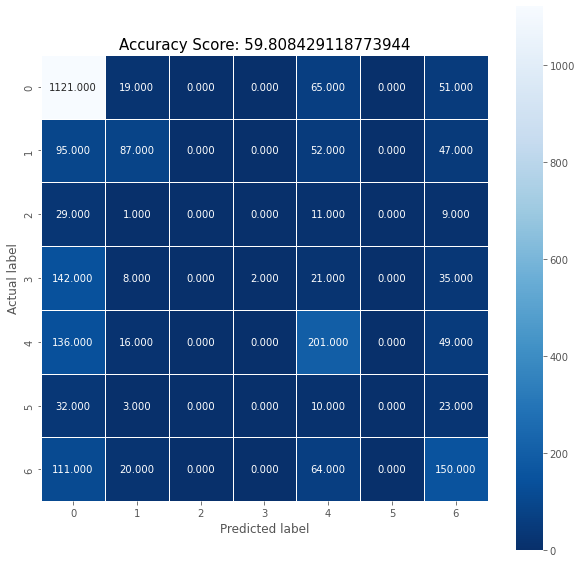

In [18]:
### View the confusion matrix as an image
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(best_label,best_pred,sample_weight=best_mask), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(best_label,best_pred,sample_weight=best_mask)*100)
plt.title(all_sample_title, size = 15)
plt.show()

#### Save model and metrics

In [19]:
cur_date = time.strftime("%d-%m", time.localtime())
filename = "emotionet_model_"+cur_date+"_"+args.feature_type+"_"

In [20]:
model_name = 'models/'+filename+str(int(round(best_fscore,0)))+'.pt'
torch.save(model.state_dict(), args.dir + model_name)
print('Model saved to {}.'.format(args.dir + model_name))

Model saved to ./MELD_features/models/emotionet_model_01-11_multimodal_54.pt.


In [21]:
# Store all training metrics per epoch in a dataframe
train_metrics = pd.DataFrame(metrics['train'])
test_metrics = pd.DataFrame(metrics['test'])
val_metrics = pd.DataFrame(metrics['val'])
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=1)
metrics.to_csv(args.dir + 'logs/'+ filename+ 'metrics.csv', index=False)
print('Metrics saved to {}.'.format(args.dir + 'logs/'+ filename+ 'metrics.csv'))

Metrics saved to ./MELD_features/logs/emotionet_model_01-11_multimodal_metrics.csv.
